# Module imports

In [1]:
import ROOT as r
import math
from array import array
import numpy as np
import thread
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Welcome to JupyROOT 6.08/02


# Set Canvas style

In [2]:
c = r.TCanvas('c1','c1',900,600)
c.SetGridx()
c.SetGridy()
c.SetTicks(1)
r.gStyle.SetOptStat(0)

# Parameters

In [3]:
startTime = 4 # in micro-secs
endTime = 400

# Retrieve and plot histogram from ROOT file

In [4]:
file = r.TFile('~/FastRotationCornellFourier/root/TMC_tAsym_p60h_t0_98.root')
fr = file.Get('h_frs')
fr.SetTitle("Toy Model Fast Rotation")
#fr.Scale(1/66666.)

Info in <TCanvas::Print>: eps file ToyModelFRS.eps has been created


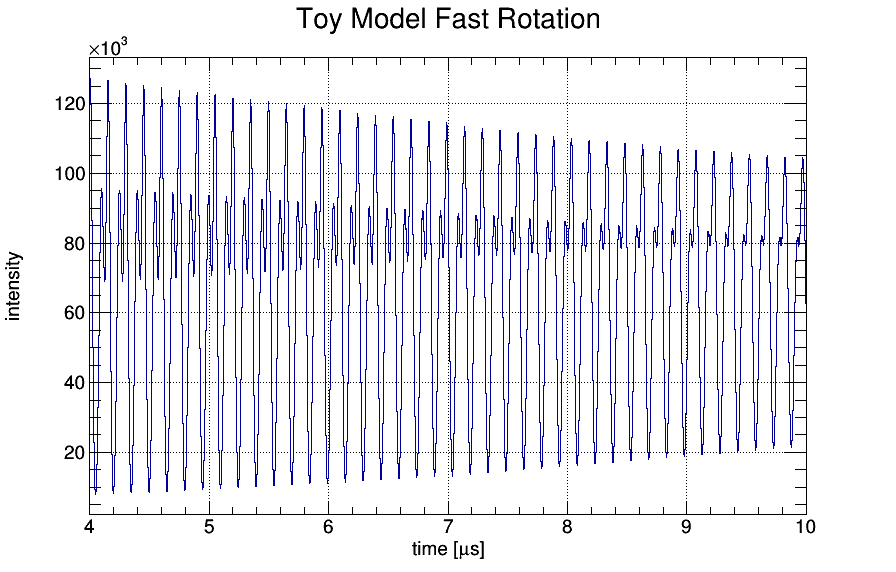

In [5]:
fr.Draw()
fr.GetXaxis().SetRangeUser(4,10)
c.Draw("hist")   
c.Print("ToyModelFRS.eps")

# Real transform

In [6]:
startBin = fr.FindBin(startTime) 
endBin   = fr.FindBin(endTime)

# Copy histogram to numpy array
# Need intermediate list step for good performance
# Otherwise need to copy over and over the array to itself addingt one value...
binCenter = np.array([])
binContent = np.array([])
a = []
b = []
for j in range(startBin, endBin):
    a.append( fr.GetBinContent(j) )
    b.append( fr.GetBinCenter(j) )   
binContent = np.asarray(a)  
binCenter = np.asarray(b)    


In [7]:
# Compute the cosine transform
def calc_freq_dist(t0):
    
    startBin = fr.FindBin(startTime)
    endBin   = fr.FindBin(endTime)
        
    for i in range(150):
        frequency = 6.6305 + i*0.001
        integral = binContent*np.cos(2*math.pi*frequency*(binCenter-t0))*0.001
        real.SetBinContent(i+1, (np.sum(integral))) 

Info in <TCanvas::Print>: eps file Real_0.1024.eps has been created


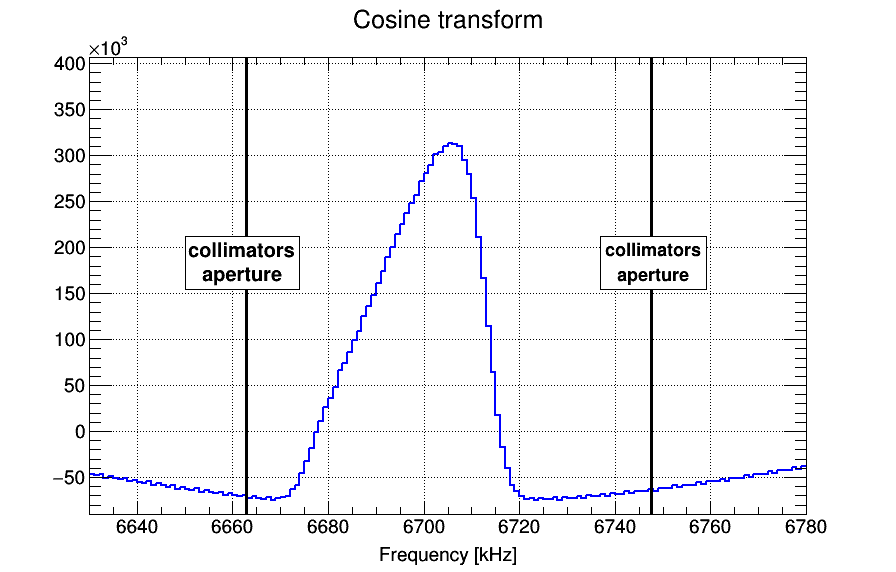

In [8]:
intensity, radius, minDelta, t0Array = array( 'd' ), array( 'd' ), array( 'd' ), array( 'd' )

for i in range(1):
    
    real = r.TH1D("freq","freq",150,6630,6780)
    t0 = 0.10245 + 0.00002*i
    calc_freq_dist(t0)
    
    real.GetXaxis().SetRangeUser(6630, 6700)
    minBin1 = real.GetMinimum()
    real.GetXaxis().SetRangeUser(6700, 6780)
    minBin2 = real.GetMinimum()
    real.GetXaxis().SetRangeUser(6630, 6780)
    
    minDelta.append(minBin1-minBin2)
    t0Array.append(t0)
    
    realClone = real.Clone()
    #realClone.SetTitle('Real transform (t0= {0:.4f} #mus)'.format(t0))
    realClone.SetTitle("Cosine transform")
    realClone.GetXaxis().SetTitle("Frequency [kHz]")
    realClone.GetXaxis().CenterTitle()
    realClone.GetXaxis().SetTitleOffset(1.3)
    realClone.SetLineColor(4)
    realClone.SetLineWidth(2)
    
    realClone.SetMaximum( realClone.GetMaximum()*1.3 ) 
    realClone.SetMinimum( realClone.GetMinimum()*1.2 ) 
    
    innerLine = r.TLine(6662.799323395121, realClone.GetMinimum(), 6662.799323395121, realClone.GetMaximum())
    innerLine.SetLineWidth(3)
    outerLine = r.TLine(6747.651727400435, realClone.GetMinimum(), 6747.651727400435, realClone.GetMaximum())
    outerLine.SetLineWidth(3)    

    pt=r.TPaveText(6650,realClone.GetMaximum()*0.38,6674,realClone.GetMaximum()*0.52);
    pt2=r.TPaveText(6737,realClone.GetMaximum()*0.38,6759,realClone.GetMaximum()*0.52);
    pt.AddText("collimators");
    pt.AddText("aperture");
    pt.SetShadowColor(0);
    pt.SetBorderSize(1);
    pt.SetFillColor(0);
    pt.SetLineWidth(1);
    pt.SetLineColor(1);
    pt.SetTextAngle(90);
    pt2.AddText("collimators");
    pt2.AddText("aperture");
    pt2.SetShadowColor(0);
    pt2.SetBorderSize(1);
    pt2.SetFillColor(0);
    pt2.SetLineWidth(1);
    pt2.SetLineColor(1);
    pt2.SetTextAngle(90);    
    
    realClone.Draw()
    innerLine.Draw("same")
    outerLine.Draw("same")
    pt.Draw("same")
    pt2.Draw("same")
    
    c.Draw()
    c.Print('Real_{0:.4f}.eps'.format(t0))
    
    f = r.TFile("tm.root","RECREATE")
    real.Write("real")
    f.Close()

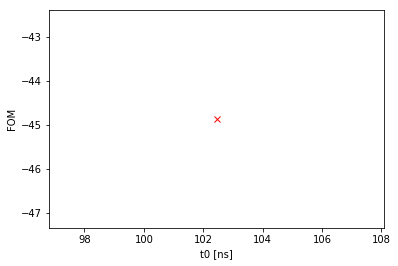

In [9]:
scaledt0Array = [i * 1000 for i in t0Array]

def func(x, a, b, ):
    return a * x * x + b

#parameter, covariance_matrix = curve_fit(func, scaledt0Array, minDelta)
#x = np.linspace(min(scaledt0Array), max(scaledt0Array), 5)

plt.plot(scaledt0Array, minDelta, 'rx', label='data')
plt.ylabel('FOM')
plt.xlabel('t0 [ns]')
#plt.plot(x, func(x, *parameter), '-b', label='fit')
plt.savefig('t0Opt_TM1_fine.eps', format='eps')
plt.show()

# First Apprxomiation

Info in <TCanvas::Print>: eps file FirstApproximation.eps has been created


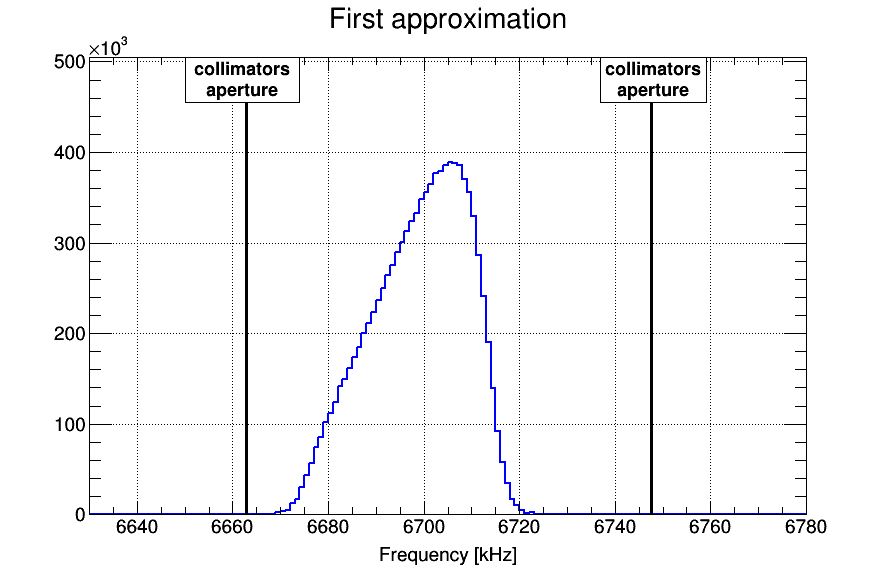

In [10]:
f = r.TFile("tm.root")
real = f.Get("real")

approx = real.Clone()
real.Draw()
c.Draw()

maxBin = approx.GetMaximumBin()

approx.GetXaxis().SetRangeUser(6630, 6700)
minBin1 = approx.GetMinimumBin()

approx.GetXaxis().SetRangeUser(6700, 6780)
minBin2 = approx.GetMinimumBin()

#print minBin1, freq.GetBinContent(minBin1), minBin2, freq.GetBinContent(minBin2)

minA =  (approx.GetBinContent(minBin1) + approx.GetBinContent(minBin2)) / 2

for iBin in range(1, minBin1):
    approx.SetBinContent(iBin, 0)
    
for iBin in range(minBin2+1, 151):
    approx.SetBinContent(iBin, 0)    
    
approx.GetXaxis().SetRangeUser(6630, 6780)    

for iBin in range(minBin1, minBin2+1):
    approx.AddBinContent(iBin, -1*minA)
    
approxClone = approx
approxClone.SetTitle("First approximation")    
    
approxClone.GetXaxis().SetTitle("Frequency [kHz]")
approxClone.GetXaxis().CenterTitle()
approxClone.GetXaxis().SetTitleOffset(1.3)
approxClone.SetLineColor(4)
approxClone.SetLineWidth(2)
    
approxClone.SetMaximum( approxClone.GetMaximum()*1.3 ) 
approxClone.SetMinimum( -0.5 ) 
    
innerLine = r.TLine(6662.799323395121, approxClone.GetMinimum(), 6662.799323395121, approxClone.GetMaximum())
innerLine.SetLineWidth(3)
outerLine = r.TLine(6747.651727400435, approxClone.GetMinimum(), 6747.651727400435, approxClone.GetMaximum())
outerLine.SetLineWidth(3)    

pt=r.TPaveText(6650,approxClone.GetMaximum()*0.9,6674,approxClone.GetMaximum()*1);
pt2=r.TPaveText(6737,approxClone.GetMaximum()*0.9,6759,approxClone.GetMaximum()*1);
pt.AddText("collimators");
pt.AddText("aperture");
pt.SetShadowColor(0);
pt.SetBorderSize(1);
pt.SetFillColor(0);
pt.SetLineWidth(1);
pt.SetLineColor(1);
pt.SetTextAngle(90);
pt2.AddText("collimators");
pt2.AddText("aperture");
pt2.SetShadowColor(0);
pt2.SetBorderSize(1);
pt2.SetFillColor(0);
pt2.SetLineWidth(1);
pt2.SetLineColor(1);
pt2.SetTextAngle(90);    

approxClone.Draw()
innerLine.Draw("same")
outerLine.Draw("same")
pt.Draw("same")
pt2.Draw("same")   
c.Draw()    

c.Print("FirstApproximation.eps")

# Delta Correction

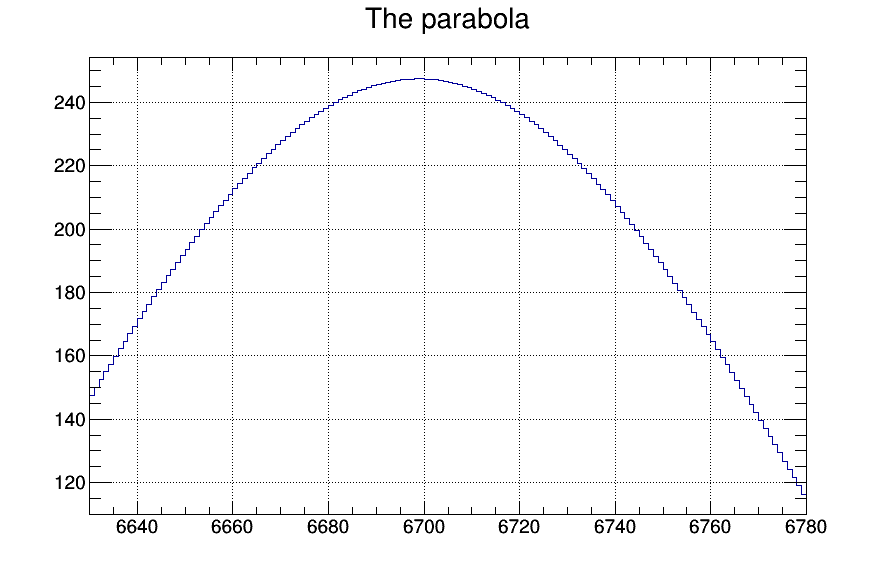

In [11]:
# Correction
rcorrs = real.Clone()
rcorrs.Scale(0)
for i in range(150):

        frq = 6630.5 + i*1
        integral = 0

        for j in range(1, 150):
            #print j, freq.GetBinCenter(j), freq.GetBinContent(j), frq
            if (approx.GetBinCenter(j)-frq) != 0:
                integral += approx.GetBinContent(j)*math.sin(2*math.pi*(frq-approx.GetBinCenter(j))*(startTime-0.10245)/1000)/(1000*(frq-approx.GetBinCenter(j))  )
            else:
                integral += 2*math.pi*approx.GetBinContent(j)*(startTime-0.10245)/1000000

        rcorrs.SetBinContent(i+1,integral)
rcorrs.Draw()
rcorrs.SetTitle("The parabola")
c.Update()
c.Draw()

# 'a' and 'b'optimization

In [12]:
# a and b minimization
def minimization():


    x = []
    y = []

    for i in range(32):
        x.append(rcorrs.GetBinContent(i+1))
        y.append(real.GetBinContent(i+1))
        x.append(rcorrs.GetBinContent(150-i))
        y.append(real.GetBinContent(150-i))

    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y,rcond=None)[0]

    return m, c

-314.500676125 -2056.07599981


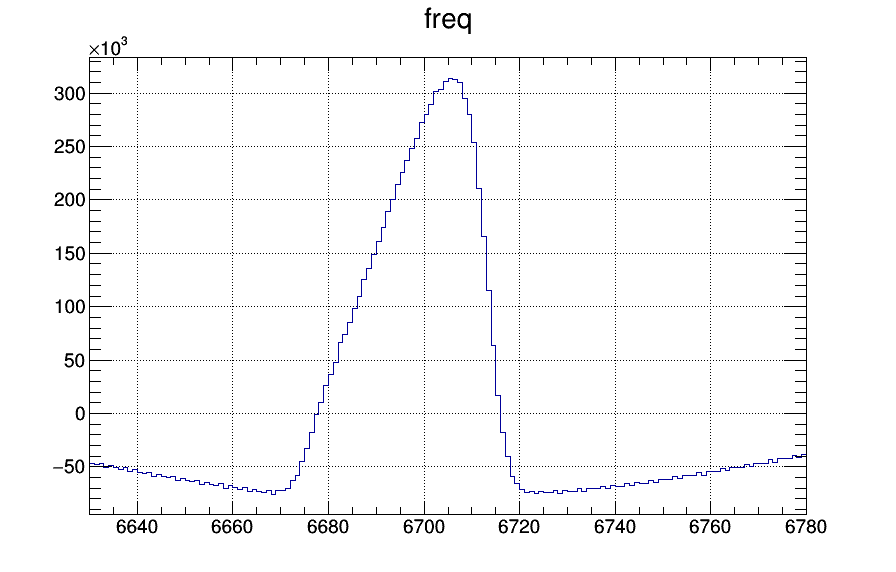

In [13]:
real.Draw()
c.Draw()
a,b = minimization()
print a,b

# Scaled parabola

Info in <TCanvas::Print>: eps file Parabola.eps has been created


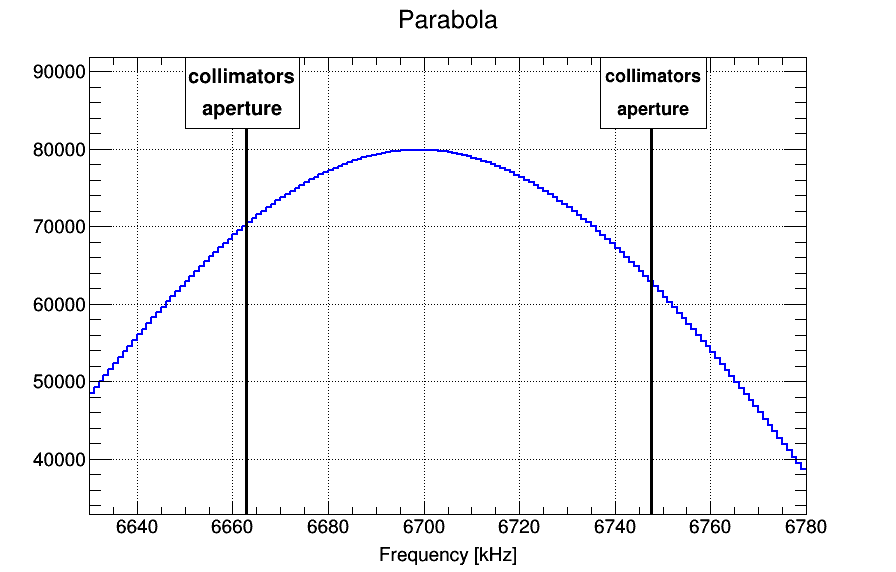

In [14]:
for iBin in range(1,151):
    rcorrs.SetBinContent(iBin, -1*( a*rcorrs.GetBinContent(iBin)+b) )
    
    
rcorrsClone = rcorrs.Clone()
rcorrsClone.SetTitle("Parabola")    
    
rcorrsClone.GetXaxis().SetTitle("Frequency [kHz]")
rcorrsClone.GetXaxis().CenterTitle()
rcorrsClone.GetXaxis().SetTitleOffset(1.3)
rcorrsClone.SetLineColor(4)
rcorrsClone.SetLineWidth(2)
    
rcorrsClone.SetMaximum( rcorrsClone.GetMaximum()*1.15 ) 
rcorrsClone.SetMinimum( rcorrsClone.GetMinimum()*0.85 ) 
    
innerLine = r.TLine(6662.799323395121, rcorrsClone.GetMinimum(), 6662.799323395121, rcorrsClone.GetMaximum())
innerLine.SetLineWidth(3)
outerLine = r.TLine(6747.651727400435, rcorrsClone.GetMinimum(), 6747.651727400435, rcorrsClone.GetMaximum())
outerLine.SetLineWidth(3)    

pt=r.TPaveText(6650,rcorrsClone.GetMaximum()*0.9,6674,rcorrsClone.GetMaximum()*1);
pt2=r.TPaveText(6737,rcorrsClone.GetMaximum()*0.9,6759,rcorrsClone.GetMaximum()*1);
pt.AddText("collimators");
pt.AddText("aperture");
pt.SetShadowColor(0);
pt.SetBorderSize(1);
pt.SetFillColor(0);
pt.SetLineWidth(1);
pt.SetLineColor(1);
pt.SetTextAngle(90);
pt2.AddText("collimators");
pt2.AddText("aperture");
pt2.SetShadowColor(0);
pt2.SetBorderSize(1);
pt2.SetFillColor(0);
pt2.SetLineWidth(1);
pt2.SetLineColor(1);
pt2.SetTextAngle(90);    
    
rcorrsClone.Draw()
innerLine.Draw("same")
outerLine.Draw("same")
pt.Draw("same")
pt2.Draw("same")    
c.Draw()    
c.Print("Parabola.eps")    

# Complete distribution

Info in <TCanvas::Print>: eps file CompleteDistribution.eps has been created


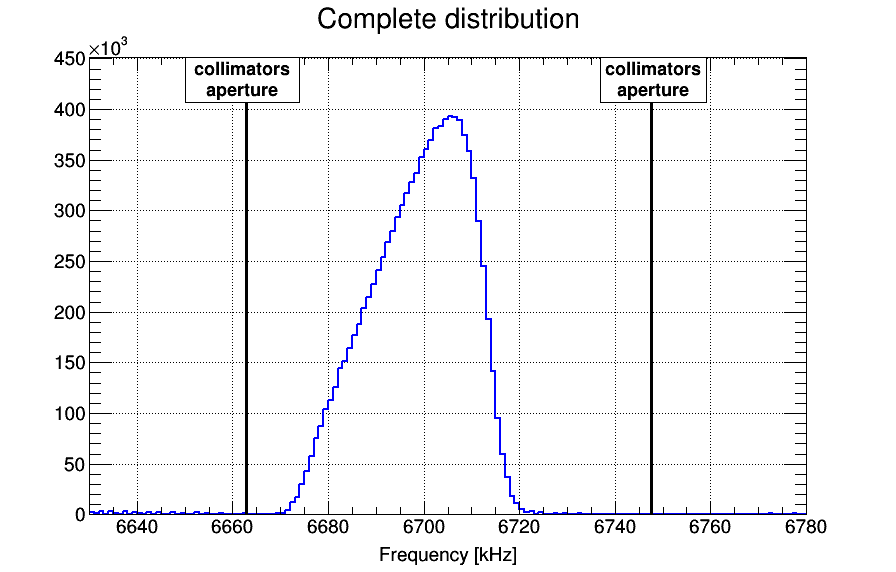

In [15]:
full = real.Clone()
for iBin in range(1,151):
    full.AddBinContent(iBin, rcorrs.GetBinContent(iBin) )
full.SetTitle("Complete distribution")    

fullClone = full.Clone()
fullClone.SetTitle("Complete distribution")    
    
fullClone.GetXaxis().SetTitle("Frequency [kHz]")
fullClone.GetXaxis().CenterTitle()
fullClone.GetXaxis().SetTitleOffset(1.3)
fullClone.SetLineColor(4)
fullClone.SetLineWidth(2)
    
fullClone.SetMaximum( fullClone.GetMaximum()*1.15 ) 
fullClone.SetMinimum( -0.5 ) 
    
innerLine = r.TLine(6662.799323395121, fullClone.GetMinimum(), 6662.799323395121, fullClone.GetMaximum())
innerLine.SetLineWidth(3)
outerLine = r.TLine(6747.651727400435, fullClone.GetMinimum(), 6747.651727400435, fullClone.GetMaximum())
outerLine.SetLineWidth(3)    

pt=r.TPaveText(6650,fullClone.GetMaximum()*0.9,6674,fullClone.GetMaximum()*1);
pt2=r.TPaveText(6737,fullClone.GetMaximum()*0.9,6759,fullClone.GetMaximum()*1);
pt.AddText("collimators");
pt.AddText("aperture");
pt.SetShadowColor(0);
pt.SetBorderSize(1);
pt.SetFillColor(0);
pt.SetLineWidth(1);
pt.SetLineColor(1);
pt.SetTextAngle(90);
pt2.AddText("collimators");
pt2.AddText("aperture");
pt2.SetShadowColor(0);
pt2.SetBorderSize(1);
pt2.SetFillColor(0);
pt2.SetLineWidth(1);
pt2.SetLineColor(1);
pt2.SetTextAngle(90);    
    
fullClone.Draw()
innerLine.Draw("same")
outerLine.Draw("same")
pt.Draw("same")
pt2.Draw("same")    
c.Draw()    
c.Print("CompleteDistribution.eps")    

# Compare with truth

full -  6698.63366489  +-  9.9166014947
truth -  6698.75983139  +-  10.051165049


Info in <TCanvas::Print>: eps file TruthReco.eps has been created


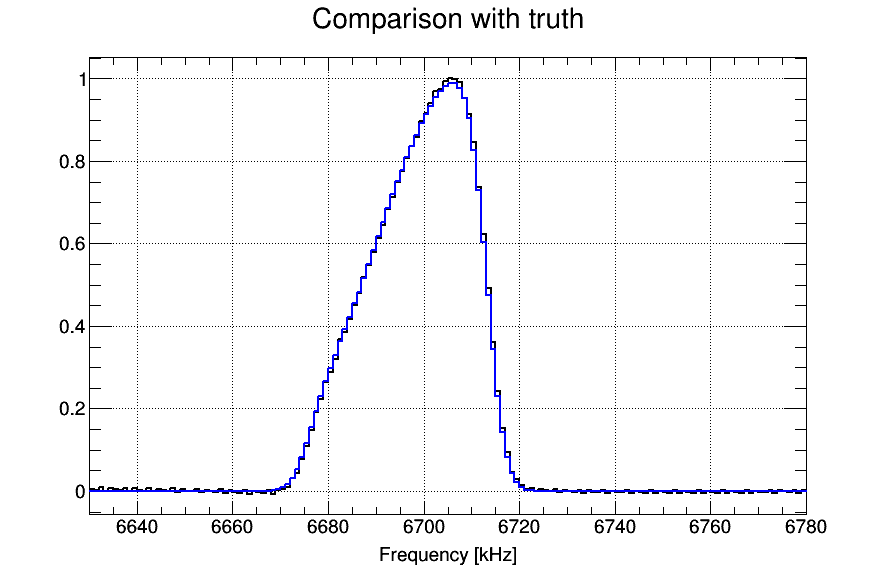

In [16]:
file = r.TFile('~/FastRotationCornellFourier/root/TMC_tAsym_p60h_t0_98.root')
freq = file.Get('h_freq')

freq.Scale(1/freq.GetMaximum())
full.Scale(1/full.GetMaximum())

full.SetLineColor(2)
full.GetXaxis().SetRangeUser(6660, 6750)
full.GetXaxis().SetRangeUser(6630, 6780)
full.Draw("hist")

full.SetTitle("Comparison with truth")
full.GetXaxis().SetTitle("Frequency [kHz]")
full.GetXaxis().CenterTitle()
full.GetXaxis().SetTitleOffset(1.3)
full.SetLineColor(1) # blue
full.SetLineWidth(2)

freq.SetLineColor(4)
freq.SetLineWidth(2)

freq.Draw("samehist")

#freq.Add(full,-1)
#freq.Draw("hist")
freq.Rebin(10)
freq.Scale(1/10.)
#freq.Add(full,-1)
#freq.Draw("hist")


c.Draw()
c.Print("TruthReco.eps")
print 'full - ', full.GetMean(), ' +- ', full.GetRMS()
print 'truth - ', freq.GetMean(), ' +- ', freq.GetRMS()

# Conversion frequency -> radius

In [17]:
muonMass = .1056583745
magicP = 3.094
E = math.sqrt(muonMass*muonMass+magicP*magicP)
gamma = E / muonMass
beta = magicP / ( gamma * muonMass )
speed = beta * 299792458
print 'Total Energy = ', E
print 'Gamma = ', gamma
print 'Beta = ', beta
print 'Speed = ', speed, ' m/s'

Total Energy =  3.09580356161
Gamma =  29.3001248246
Beta =  0.999417417295
Speed =  299617804.099  m/s


C_E truth -600.550936337  ppb
C_E reco   -595.345349129  ppb


Error in <TFile::WriteTObject>: Directory /home/achapela/FastRotationCornellFourier/root/TMC_tAsym_p60h_t0_98.root is not writable
Info in <TCanvas::Print>: eps file RadialTruthReco.eps has been created


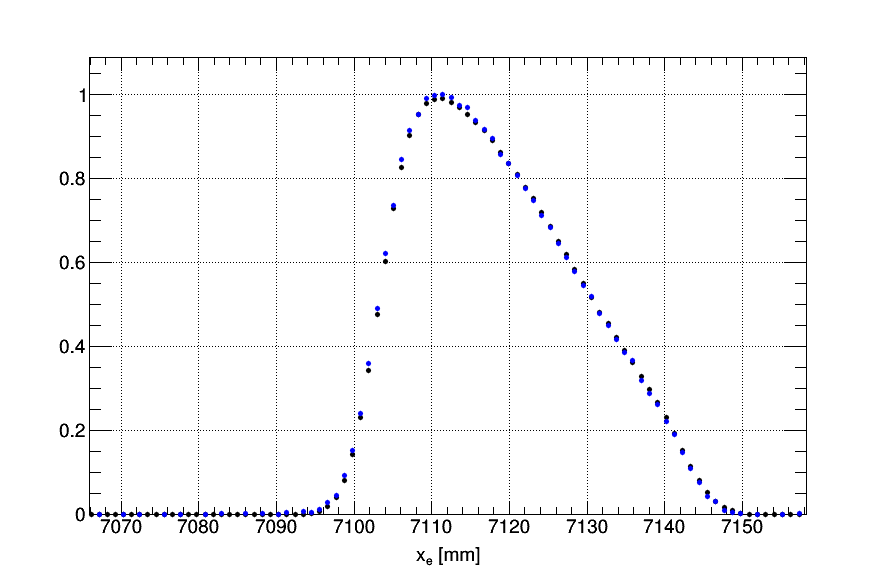

In [18]:
intensity, radius = array( 'd' ), array( 'd' )

for i in range(1, 150):
    #print i, full.GetBinCenter(i)
    radius.append( speed / (2*math.pi*full.GetBinCenter(i)) )
    intensity.append( full.GetBinContent(i))

xe = np.average(radius, axis=0, weights=intensity)    
    
graph = r.TGraph(150,radius,intensity)

graph.GetXaxis().SetRangeUser(7067,7157)
graph.SetMarkerStyle(20)
graph.SetMarkerSize(0.6)
graph.SetMarkerColor(4)

intensityT, radiusT, product = array( 'd' ), array( 'd' ), array( 'd' )
for i in range(1, 150):
    radiusT.append( speed / (2*math.pi*freq.GetBinCenter(i)) )
    intensityT.append( freq.GetBinContent(i))

xeT = np.average(radiusT, axis=0, weights=intensityT)    
    
graphT = r.TGraph(149,radiusT,intensityT)
graphT.SetTitle('Comparison with truth')
graphT.GetXaxis().SetTitle("x_{e} [mm]")
graphT.GetYaxis().SetTitle("")
graphT.GetXaxis().CenterTitle()
graphT.GetXaxis().SetTitleOffset(1.3)
graphT.GetXaxis().SetRangeUser(7067,7157)
graphT.SetMarkerStyle(20)
graphT.SetMarkerSize(0.6)
graphT.SetMarkerColor(1)

#print xe, xeT, xe-xeT   

std = 0
sum = 0
for i,j in zip(radiusT,intensityT):
    sum += j
    std += (j) * (i-7112) * (i-7112 )
    
std /= sum

#print std
print 'C_E truth', -2*beta*beta*0.108*(1-0.108)*std/(7112*7112)*1e9, ' ppb'

sum = 0
std = 0
for i,j in zip(radius,intensity):
    sum += j
    std += (j) * (i-7112) * (i-7112 )
    
std /= sum

#print std
print 'C_E reco  ', -2*beta*beta*0.108*(1-0.108)*std/(7112*7112)*1e9, ' ppb'

graphT.SetTitle("")
graphT.Draw("AP")
graph.Draw('Psame')
#graphT.Fit("gaus","","",7100,7123)
graph.Write("rad")
c.Draw()
c.Print('RadialTruthReco.eps')    

In [19]:
f.Close()